In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
# Ignore warnings

import warnings
warnings.simplefilter("ignore", category=Warning)

In [2]:
df = pd.read_csv('C:/Users/nikit/OneDrive/Desktop/data/household_power_consumption.txt', sep=';',low_memory=False, na_values=['nan','?'], nrows=1000000)

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.isnull().sum()

Date                        0
Time                        0
Global_active_power      3990
Global_reactive_power    3990
Voltage                  3990
Global_intensity         3990
Sub_metering_1           3990
Sub_metering_2           3990
Sub_metering_3           3990
dtype: int64

In [5]:
# Split date time difference into two columns
datetime_str = df['Date'] + ' ' + df['Time']

In [6]:
df['datetime'] = pd.to_datetime(datetime_str, format='%d/%m/%Y %H:%M:%S')

In [7]:
# Drop the original date and time columns
# df.drop(['Date', 'Time'], axis=1, inplace=True)

In [8]:
# Handle missing values
df.replace('?', np.nan, inplace=True)  # Replace '?' with NaN
df.dropna(inplace=True)  # Drop rows with missing values

In [9]:
# Feature Engineering
# Time Based Features Engineering

# Add a new column for the hour of the day
df["Hours"] = df["datetime"].dt.hour

# Create a new column for the day of the week
df["Day"] = df["datetime"].dt.weekday

# Create a new column for the month of the year
df["Month"] = df["datetime"].dt.month

# Create a new column for the day of the month
df["Day_of_month"] = df["datetime"].dt.day

# Create day of the week feature (0=Monday, 6=Sunday)
df['Day_of_week'] = df['datetime'].dt.dayofweek
# Calculate the active energy consumption
df["Active_energy_consumption"] = df["Global_active_power"] * 1000 / 60 - df["Sub_metering_1"] - df["Sub_metering_2"] - df["Sub_metering_3"]

# Create binary feature for weekend
df['is_weekend'] = (df['Day_of_week'] >= 5).astype(int)

# Calculate rolling mean of global active power over 3-hour window
df['rolling_mean_power'] = df['Global_active_power'].rolling(window=6).mean()

# Additional Feature Engineering
df["Active_power_ratio"] = df["Global_active_power"] / df["Voltage"]
df["Power_factor"] = df["Global_active_power"] / (df["Voltage"] * df["Global_intensity"])
df["Power_diff"] = df["Global_active_power"] - df["Global_reactive_power"]
df["Voltage_mean"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].mean(axis=1)
df["Voltage_std"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].std(axis=1)
df["Voltage_range"] = df["Voltage_std"] - df["Voltage_mean"]
df["Voltage_min"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].min(axis=1)
df["Voltage_max"] = df[["Voltage", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].max(axis=1)

In [10]:
df["Active_energy_consumption"].describe()

count    996010.000000
mean          9.669177
std          10.601850
min          -2.400000
25%           3.700000
50%           5.400000
75%          10.433333
max         124.833333
Name: Active_energy_consumption, dtype: float64

In [11]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'datetime', 'Hours', 'Day', 'Month', 'Day_of_month',
       'Day_of_week', 'Active_energy_consumption', 'is_weekend',
       'rolling_mean_power', 'Active_power_ratio', 'Power_factor',
       'Power_diff', 'Voltage_mean', 'Voltage_std', 'Voltage_range',
       'Voltage_min', 'Voltage_max'],
      dtype='object')

In [12]:
# drop the columns
df.drop(['Date','Time','datetime'], axis = 1, inplace=True)

In [13]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Hours', 'Day', 'Month', 'Day_of_month',
       'Day_of_week', 'Active_energy_consumption', 'is_weekend',
       'rolling_mean_power', 'Active_power_ratio', 'Power_factor',
       'Power_diff', 'Voltage_mean', 'Voltage_std', 'Voltage_range',
       'Voltage_min', 'Voltage_max'],
      dtype='object')

In [14]:
df.dropna(inplace=True)

In [15]:
y = df.pop('Active_energy_consumption')
X = df

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
datasets = [(X_train, "X_train"), (X_test, "X_test"), (y_train, "y_train"), (y_test, "y_test")]

for data, name in datasets:
    print(f"{name} shape:", data.shape)

X_train shape: (796804, 22)
X_test shape: (199201, 22)
y_train shape: (796804,)
y_test shape: (199201,)


In [18]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
import time
# Create a linear regression model
model = LinearRegression()

# Measure time taken for training
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

# Measure time taken for prediction
start_time = time.time()
predictions = model.predict(X_test)
end_time = time.time()
prediction_time = end_time - start_time

print("Training Time:", training_time, "seconds")
print("Prediction Time:", prediction_time, "seconds")
print("Model Score:", model.score(X_test, y_test))

Training Time: 1.0380587577819824 seconds
Prediction Time: 0.019307374954223633 seconds
Model Score: 1.0


In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def cc(y_true, y_pred):
  """Calculates the coefficient of correlation."""
  return np.corrcoef(y_true, y_pred)[0, 1]

def rae(y_true, y_pred):
  """Calculates the relative absolute error."""
  return mean_absolute_error(y_true, y_pred) / np.mean(y_true) * 100

def rrsse(y_true, y_pred):
  """Calculates the root relative squared error."""
  return np.sqrt(mean_squared_error(y_true, y_pred)) / np.var(y_true) * 100


cc = cc(y_test, predictions)
rae = rae(y_test, predictions)
rrsse = rrsse(y_test, predictions)


print('CC:', cc)
print('RAE (%):', rae)
print('RRSE (%):', rrsse)

CC: 1.0
RAE (%): 1.0520632489775778e-12
RRSE (%): 1.1476214767127285e-13


R2 score: 1.0
Mean Squared Error: 1.699048720999533e-26
Root Mean Squared Error: 1.3034756311490955e-13
Mean Absolute Error: 1.0212545341726784e-13
Adjusted R-squared: 1.0
Coefficient of Correlation: 1.0
Relative Absolute Error(%): 1.0520632489775778e-12
Root Relative Squared Error(%): 1.1476214767127285e-13


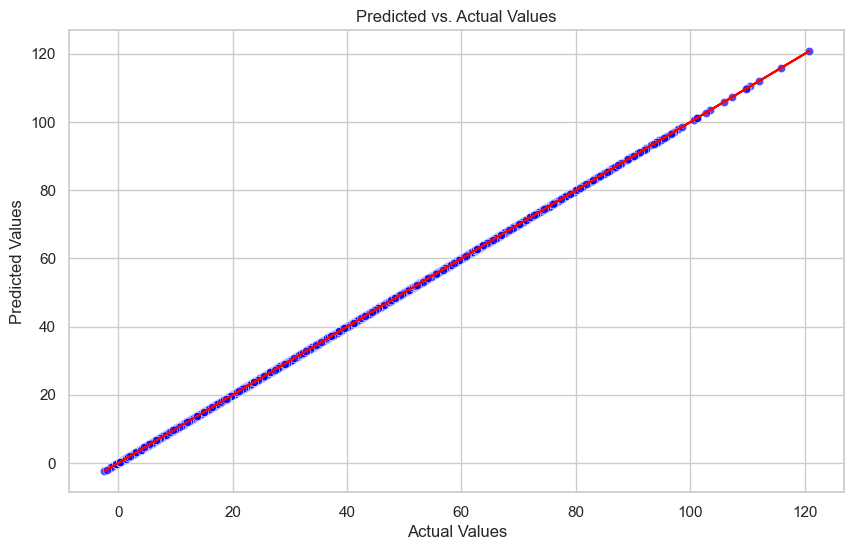

In [22]:
def evaluate_regression_model(model, X_test, y_test):
    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    
    # Calculate adjusted R-squared
    n = X_test.shape[0]  # Number of samples in the test set
    k = X_test.shape[1]  # Number of features

    # Calculate different regression metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    adjusted_r2 = 1 - (1 - model.score(X_test, y_test)) * (n - 1) / (n - k - 1)

    print("R2 score:", r2)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("Adjusted R-squared:", adjusted_r2)
    print("Coefficient of Correlation:", np.corrcoef(y_test, y_pred)[0, 1])
    print("Relative Absolute Error(%):", mean_absolute_error(y_test, y_pred) / np.mean(y_test) * 100)
    print("Root Relative Squared Error(%):", np.sqrt(mean_squared_error(y_test, y_pred)) / np.var(y_test) * 100)

    # Set style for seaborn
    sns.set(style="whitegrid")
    
    # Create a scatter plot of predicted vs. actual values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.7)
    plt.plot(y_test, y_test, color="red")  # Regression line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. Actual Values")
    plt.show()

# Call the function with your trained model and test data
evaluate_regression_model(model, X_test, y_test)

In [23]:
# if loaded_model:
#     evaluate_regression_model(loaded_model, X_test, y_test)
# else:
#     evaluate_regression_model(model, X_test, y_test)

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb  # Import XGBoost
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm 
import numpy as np

# Create a dictionary of regression algorithms
regressors = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=random_seed),
    "Random Forest": RandomForestRegressor(n_estimators=10, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=random_seed)
}

# Initialize lists to store performance metrics
r2_scores = []
mse_scores = []
rmse_scores = []
mae_scores = []
cc_scores = []
rae_scores = []
rrse_scores = []
training_times = []

# Use tqdm to loop through models and track progress
for name, model in tqdm(regressors.items()):
    print(f"Model: {name}")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    training_times.append(training_time)
    y_pred = model.predict(X_test)
    
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    rmse_scores.append(mean_squared_error(y_test, y_pred, squared=False))
    mae_scores.append(mean_absolute_error(y_test, y_pred))
    cc_scores.append(np.corrcoef(y_test, y_pred)[0, 1])
    rae_scores.append(mean_absolute_error(y_test, y_pred) / np.mean(y_test) * 100)
    rrse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)) / np.var(y_test) * 100)

# Create a DataFrame to store the performance metrics
metrics_df = pd.DataFrame({
    "Algorithm": list(regressors.keys()),
    "R2 Score": r2_scores,
    "Mean Squared Error": mse_scores,
    "Root Mean Squared Error": rmse_scores,
    "Mean Absolute Error": mae_scores,
    "Correlation Coefficient": cc_scores,
    "Relative Absolute Error(%)": rae_scores,
    "Root Relative Squared Error(%)": rrse_scores,
    "Training Time (seconds)": training_times
})


  0%|          | 0/6 [00:00<?, ?it/s]

Model: Linear Regression


 17%|█▋        | 1/6 [00:01<00:05,  1.12s/it]

Model: Ridge Regression


 33%|███▎      | 2/6 [00:01<00:03,  1.32it/s]

Model: Lasso Regression


 50%|█████     | 3/6 [00:03<00:04,  1.45s/it]

Model: Decision Tree


 67%|██████▋   | 4/6 [01:12<00:55, 27.77s/it]

Model: Random Forest


 83%|████████▎ | 5/6 [02:52<00:53, 53.83s/it]

Model: XGBoost


100%|██████████| 6/6 [06:43<00:00, 67.30s/it] 


In [25]:
metrics_df = metrics_df.round(4)
metrics_df

,Algorithm,R2 Score,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,Correlation Coefficient,Relative Absolute Error(%),Root Relative Squared Error(%),Training Time (seconds)
0,Linear Regression,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0333
1,Ridge Regression,1.0000,0.0000,0.0008,0.0005,1.0000,0.0051,0.0007,0.4006
2,Lasso Regression,0.8860,12.9518,3.5989,2.3622,0.9711,24.3349,3.1685,2.1749
3,Decision Tree,0.9989,0.1268,0.3561,0.0662,0.9994,0.6819,0.3136,67.8821
4,Random Forest,0.9953,0.5314,0.7290,0.3249,0.9977,3.3469,0.6418,99.7487
5,XGBoost,0.9989,0.1222,0.3496,0.1806,0.9995,1.8602,0.3078,230.1765


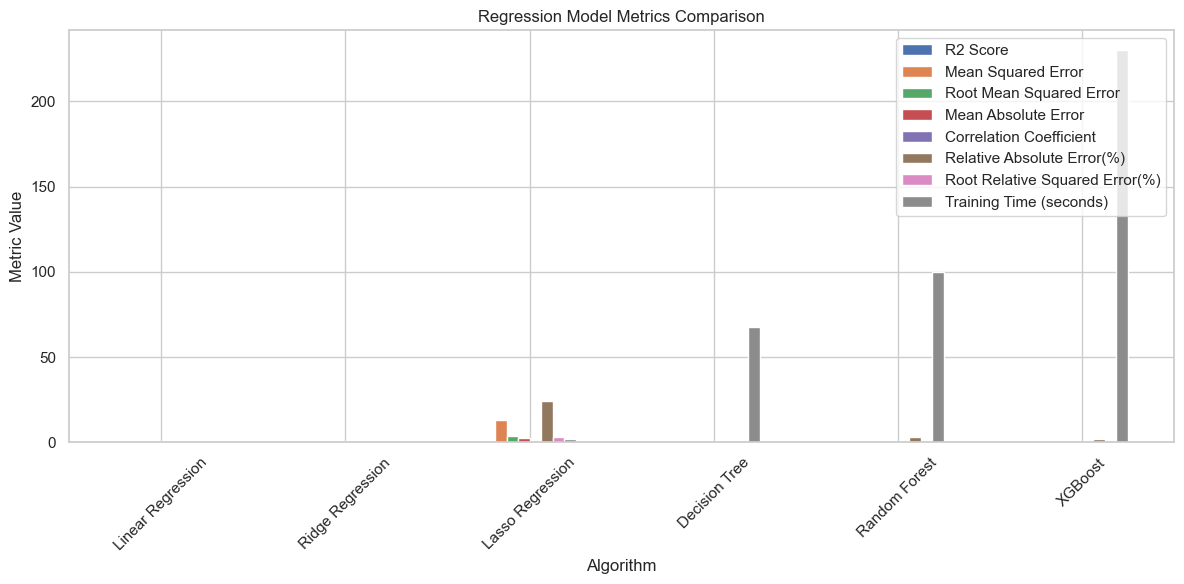

In [26]:
metrics_df.set_index("Algorithm", inplace=True)

# Create a bar plot for the metrics
metrics_df.plot(kind="bar", figsize=(12, 6))
plt.title("Regression Model Metrics Comparison")
plt.xlabel("Algorithm")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()

In [27]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
X_test = pd.DataFrame(data=X_test, columns=X.columns)
# PredictX_test

In [28]:
# Find the best algorithm based on each metric
best_r2_index = metrics_df["R2 Score"].idxmax()
best_mse_index = metrics_df["Mean Squared Error"].idxmin()
best_rmse_index = metrics_df["Root Mean Squared Error"].idxmin()
best_mae_index = metrics_df["Mean Absolute Error"].idxmin()
best_time_index = metrics_df["Training Time (seconds)"].idxmin()
best_cc_index = metrics_df["Correlation Coefficient"].idxmax()
best_rae_index = metrics_df["Relative Absolute Error(%)"].idxmin()
best_rrse_index = metrics_df["Root Relative Squared Error(%)"].idxmin()

best_r2_algorithm = metrics_df.loc[best_r2_index, "Algorithm"]
best_mse_algorithm = metrics_df.loc[best_mse_index, "Algorithm"]
best_rmse_algorithm = metrics_df.loc[best_rmse_index, "Algorithm"]
best_mae_algorithm = metrics_df.loc[best_mae_index, "Algorithm"]
best_time_algorithm = metrics_df.loc[best_time_index, "Algorithm"]
best_cc_algorithm = metrics_df.loc[best_cc_index, "Algorithm"]
best_rae_algorithm = metrics_df.loc[best_rae_index, "Algorithm"]
best_rrse_algorithm = metrics_df.loc[best_rrse_index, "Algorithm"]

# Print the best algorithms for each metric
print(f"Best algorithm based on R2 Score: {best_r2_algorithm}")
print(f"Best algorithm based on Mean Squared Error: {best_mse_algorithm}")
print(f"Best algorithm based on Root Mean Squared Error: {best_rmse_algorithm}")
print(f"Best algorithm based on Mean Absolute Error: {best_mae_algorithm}")
print(f"Best algorithm based on Time: {best_time_algorithm}")
print(f"Best algorithm based on Coefficient of Determination: {best_cc_algorithm}")
print(f"Best algorithm based on Relative Absolute Error: {best_rae_algorithm}")
print(f"Best algorithm based on Relative Relative Error: {best_rrse_algorithm}")
# Use the best algorithm to make predictions
best_algorithm = regressors[best_rmse_algorithm] 

# Train the best algorithm on the entire training data
best_algorithm.fit(X_train, y_train)

# Make predictions using the best algorithm
y_pred_best = best_algorithm.predict(X_test)

KeyError: 'Algorithm'

In [ ]:
# # Save the trained model as a pickle file
import pickle

# Assuming 'model' is your trained scikit-learn model
model_file_path  = '../model/reg_model.pkl'
# Save the model using pickle
with open(model_file_path, 'wb') as model_file:
    pickle.dump(best_algorithm, model_file)

In [ ]:
import pickle
# Specify the file path of the saved model
model_file_path = 'C:/Users/nikit/OneDrive/Desktop/DI/model/reg_model.pkl'

# Load the model using pickle
with open(model_file_path, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

print("Model loaded successfully!")

# Now you can use the loaded model for predictions

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/nikit/OneDrive/Desktop/DI/model/reg_model.pkl'

In [ ]:
X_train = pd.DataFrame(data=X_train, columns=X.columns)
X_test = pd.DataFrame(data=X_test, columns=X.columns)
# PredictX_test

In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard, InlineExplainer

# explainer = RegressionExplainer(best_algorithm, pd.DataFrame(X_test, columns=df.columns), y_test, shap='linear')
explainer = RegressionExplainer(loaded_model, X_test, y_test)
db = ExplainerDashboard(explainer)
db.run(port=8000)

Generating self.shap_explainer = shap.LinearExplainer(modelX)...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.181.53:8000


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8000): Max retries exceeded with url: /_alive_022a743e-b661-489a-b697-411a1ba32c5b (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000017A9426AD00>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))

R2 score: 1.0
Mean Squared Error: 1.699048720999533e-26
Root Mean Squared Error: 1.3034756311490955e-13
Mean Absolute Error: 1.0212545341726784e-13
Adjusted R-squared: 1.0
Coefficient of Correlation: 1.0
Relative Absolute Error(%): 1.0520632489775778e-12
Root Relative Squared Error(%): 1.1476214767127285e-13


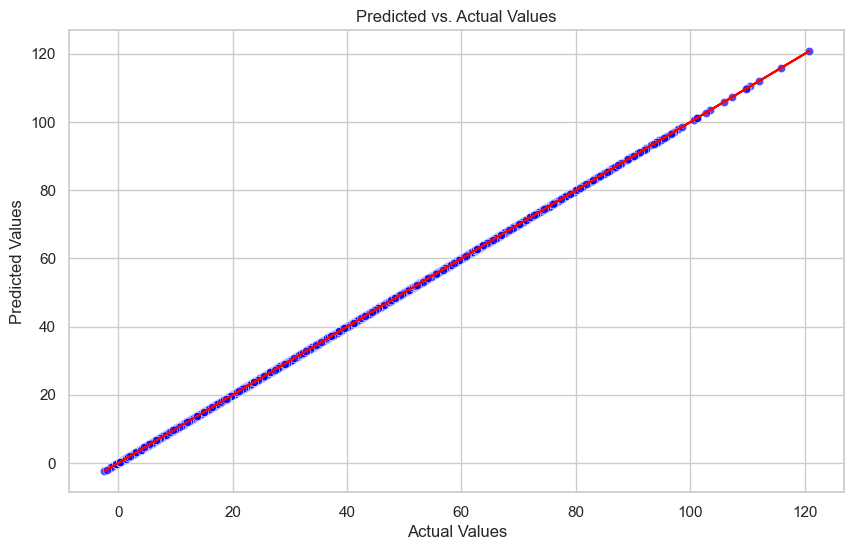

In [ ]:
# Call the function with your trained model and test data
evaluate_regression_model(loaded_model, X_test, y_test)

In [ ]:
db.terminate(8000)      

Trying to shut down dashboard on port 8000...
